version of torch: 1.13.1+cpu, torch cuda is available: False
开始预测
预测完毕


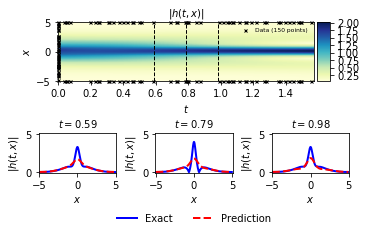

In [1]:
import numpy as np
import torch
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
import scipy.io
from time import time
import os
from scipy.interpolate import griddata
from pyDOE import lhs
from matplotlib import gridspec
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm
%matplotlib inline
print(f"version of torch: {torch.__version__}, torch cuda is available: {torch.cuda.is_available()}")
# 随机种子
np.random.seed(1234)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 定义 PINN 类: 网络结构
class PINN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        # 定义网络
        self.net = nn.Sequential(
            nn.Linear(layers[0], layers[1]),
            nn.Tanh(),
            nn.Linear(layers[1], layers[2]),
            nn.Tanh(),
            nn.Linear(layers[2], layers[3]),
            nn.Tanh(),
            nn.Linear(layers[3], layers[4]),
            nn.Tanh(),
            nn.Linear(layers[4], layers[5]),
        )
        # 初始化偏置
        self.init_bias()

    # 初始化偏置
    def init_bias(self):
        for layer in self.net.children():
            if isinstance(layer, nn.Linear):
                # 权重采用Xavier正态初始化
                nn.init.xavier_normal_(layer.weight, gain=5 / 3)  # gain 根据激活函数选择, torch.nn.init.calculate_gain()查看
                # 偏置置0
                nn.init.constant_(layer.bias, 0.)

    # 前向传播
    def forward(self, x, t):
        xt = torch.cat((x, t), dim=1)
        xt = self.net(xt)

        u = xt[:, 0].unsqueeze(-1)
        v = xt[:, 1].unsqueeze(-1)
        return u, v


class PINNSolver:
    def __init__(self, model, x0, u0, v0, tb, X_f, lb, ub):
        self.lb = torch.from_numpy(lb.astype(np.float32)).to(device)
        self.ub = torch.from_numpy(ub.astype(np.float32)).to(device)
        self.u0 = torch.from_numpy(u0.astype(np.float32)).to(device)
        self.v0 = torch.from_numpy(v0.astype(np.float32)).to(device)

        # 左边界
        X0 = np.concatenate((x0, 0 * x0), 1)  # (x0, 0)
        self.x0 = torch.from_numpy(X0[:, 0:1].astype(np.float32)).to(device)
        self.t0 = torch.from_numpy(X0[:, 1:2].astype(np.float32)).to(device)

        #
        X_lb = np.concatenate((0 * tb + lb[0], tb), 1)  # (lb[0], tb)
        X_ub = np.concatenate((0 * tb + ub[0], tb), 1)  # (ub[0], tb)
        self.x_lb = torch.from_numpy(X_lb[:, 0:1].astype(np.float32)).to(device)
        self.t_lb = torch.from_numpy(X_lb[:, 1:2].astype(np.float32)).to(device)
        self.x_ub = torch.from_numpy(X_ub[:, 0:1].astype(np.float32)).to(device)
        self.t_ub = torch.from_numpy(X_ub[:, 1:2].astype(np.float32)).to(device)

        self.x_f = torch.from_numpy(X_f[:, 0:1].astype(np.float32)).to(device)
        self.t_f = torch.from_numpy(X_f[:, 1:2].astype(np.float32)).to(device)

        self.model = model

    # 前向传播并获取梯度信息
    def get_grad(self, model, x, t, fist_gras=False, second_grad=False):
        # 前向传播
        x.requires_grad, t.requires_grad = True, True
        u, v = model(x, t)

        if not (fist_gras or second_grad):
            return u, v

        if fist_gras:
            # 计算一阶导数
            u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
            v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]
            u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
            v_t = torch.autograd.grad(v, t, grad_outputs=torch.ones_like(v), create_graph=True)[0]
            if second_grad:
                # 计算二阶导数
                u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
                v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), create_graph=True)[0]
                return u, v, u_x, v_x, u_t, v_t, u_xx, v_xx
            return u, v, u_x, v_x, u_t, v_t

    # 损失函数定义
    def loss_fn(self, model):
        # 计算预测值和梯度
        u0_pred, v0_pred = self.get_grad(model, self.x0, self.t0,
                                         fist_gras=False, second_grad=False)
        u_lb_pred, v_lb_pred, u_lb_x, v_lb_x, _, _ = self.get_grad(model, self.x_lb, self.t_lb,
                                                                   fist_gras=True, second_grad=False)
        u_ub_pred, v_ub_pred, u_ub_x, v_ub_x, _, _ = self.get_grad(model, self.x_ub, self.t_ub,
                                                                   fist_gras=True, second_grad=False)
        u_f_pred, v_f_pred, _, _, u_f_t, v_f_t, u_f_xx, v_f_xx = self.get_grad(model, self.x_f, self.t_f,
                                                                               fist_gras=True, second_grad=True)
        # 损失函数
        l1 = torch.mean(torch.square(u0_pred - self.u0))
        l2 = torch.mean(torch.square(v0_pred - self.v0))
        l3 = torch.mean(torch.square(u_lb_pred - u_ub_pred))
        l4 = torch.mean(torch.square(v_lb_pred - v_ub_pred))
        l5 = torch.mean(torch.square(u_lb_x - u_ub_x))
        l6 = torch.mean(torch.square(v_lb_x - v_ub_x))
        l7 = torch.mean(torch.square(u_f_t+0.5*v_f_xx+(torch.square(u_f_pred)+torch.square(v_f_pred))*v_f_pred))
        l8 = torch.mean(torch.square((-1)*v_f_t+0.5*u_f_xx+(torch.square(u_f_pred)+torch.square(v_f_pred))*u_f_pred))

        loss = l1 + l2 + l3 + l4 + l5 + l6 + l7 + l8

        return loss

    # 训练
    def train(self, nIter, file_path):
        # 优化器
        optim = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        # 学习率衰减
        scheduler = ReduceLROnPlateau(optim, factor=0.1, patience=100, verbose=True)
        # 开始训练时间
        t0 = time()
        # 开始训练
        for epoch in tqdm(range(nIter)):
            loss = self.loss_fn(self.model)
            # 清零梯度
            optim.zero_grad()
            # 反向传播
            loss.backward()
            # 更新参数
            optim.step()
            # 更新学习率
            scheduler.step(loss)

            # print(f"Iteration={epoch+1}, loss={loss.cpu().detach().numpy()}")
            if epoch % 100 == 0:
                tqdm.write(f"Iteration={epoch:04d}, loss={loss.cpu().detach().numpy():.5f}")
            if epoch % 500 == 0:
                torch.save(model.state_dict(), file_path)
        # 训练时间
        print(f"TrainTime: {time()-t0:0.4f} seconds")


    # 预测
    def predict(self, X_start, u_start, v_start, h_start):
        print("开始预测")
        x_start = torch.from_numpy(X_start[:, 0].astype(np.float32)).reshape(-1, 1).to(device)
        t_start = torch.from_numpy(X_start[:, 1].astype(np.float32)).reshape(-1, 1).to(device)
        u, v, u_x, v_x, u_t, v_t, u_xx, v_xx = self.get_grad(self.model, x_start, t_start, fist_gras=True, second_grad=True)
        h = torch.sqrt(u ** 2 + v ** 2)
        f_u_star = torch.square(u_t+0.5*v_xx+(torch.square(u)+torch.square(v))*v)
        f_v_star = torch.square((-1)*v_t+0.5*u_xx+(torch.square(u)+torch.square(v))*u)

        # 误差(二范数)
        # print("计算误差")
        # error_u = np.linalg.norm(u_start - u.cpu().detach().numpy(), 2) / np.linalg.norm(u_start, 2)
        # error_v = np.linalg.norm(v_start - v.cpu().detach().numpy(), 2) / np.linalg.norm(v_start, 2)
        # error_h = np.linalg.norm(h_start - h.cpu().detach().numpy(), 2) / np.linalg.norm(h_start, 2)
        # print(f'Error u: {error_u}')
        # print(f'Error v: {error_v}')
        # print(f'Error h: {error_h}')
        print("预测完毕")

        return u, v, h, f_u_star, f_v_star


# 得到图片大小
def figsize(scale, nplots=1.0):
    fig_width_pt = 390.0    # Latex 中文本的宽度
    inches_per_pt = 1.0 / 72.27  # 字号: 1 inch = 72 pt
    golden_mean = (np.sqrt(5.0) - 1.0) / 2.0
    fig_width = fig_width_pt * inches_per_pt * scale    # width in inches
    fig_height = nplots * fig_width * golden_mean   # height in inches
    fig_size = [fig_width, fig_height]
    return fig_size

# 创建新图片
def newfig(width, nplots=1.0):
    fig = plt.figure(figsize=figsize(width, nplots))
    ax = fig.add_subplot(111)
    return fig, ax


if __name__ == '__main__':
    # #################### 初始化变量 #######################
    lb = np.array([-5., 0.])  # 下边界
    ub = np.array([5., np.pi/2])  # 上边界
    N0 = 50
    Nb = 50
    Nf = 20000
    layers = [2, 100, 100, 100, 100, 2]
    # ##################### 加载数据和处理 ########################
    data = scipy.io.loadmat(r'C:\Users\Fan\JupyterFile\PINNs-maziarraissi\main\Data\NLS.mat')  # scipy.io.loadmat 将 mat文件加载为 Python字典
    t = data['tt'].flatten()[:, None]  # (201, 1)
    x = data['x'].flatten()[:, None]  # (256, 1)
    Exact = data['uu']  # (256, 201)
    Exact_u = np.real(Exact).astype(np.float32)  # 实部
    Exact_v = np.imag(Exact).astype(np.float32)  # 虚部
    Exact_h = np.sqrt(Exact_u ** 2 + Exact_v ** 2)  # 模

    X, T = np.meshgrid(x, t)  # X(201, 256) T(201, 256)

    X_start = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))  # (51456, 2)
    u_start = Exact_u.flatten()[: None]  # (51456,)
    v_start = Exact_v.flatten()[: None]  # (51456,)
    h_start = Exact_h.flatten()[: None]  # (51456,)

    idx_t = np.random.choice(t.shape[0], Nb, replace=False)
    tb = t[idx_t, :]

    idx_x = np.random.choice(x.shape[0], N0, replace=False)
    x0 = x[idx_x, :]
    u0 = Exact_u[idx_x, 0:1]
    v0 = Exact_v[idx_t, 0:1]
    # 拉丁超立方采样
    X_f = lb + (ub - lb) * lhs(2, Nf)

    # ###################### 模型实例化 ###########################
    model = PINN(layers).to(device)
    Insolver = PINNSolver(model, x0, u0, v0, tb, X_f, lb, ub)

    # #################### 训练、验证网络 ##########################
    folder_path = os.getcwd()   # 获取当前程序路径
    file_name = 'PINNs_freshman_ip_model.pkl'    # 保存的训练模型名称
    file_path = folder_path + file_name

    if os.path.exists(file_path) and os.path.isfile(file_path):
        # 已经训练完成 直接加载模型
        model.load_state_dict(torch.load(file_path))
    else:
        # 未训练模型 进行模型训练
        Insolver.train(5000, file_path)
        # 保存模型
        torch.save(model.state_dict(), file_path)

    u_pred, v_pred, h_pred, f_u_pred, f_v_pred = Insolver.predict(X_start, u_start, v_start, h_start)

    U_pred = griddata(X_start, u_pred.to('cpu').detach().numpy().flatten(), (X, T), method='cubic')  # (201, 256)
    V_pred = griddata(X_start, v_pred.to('cpu').detach().numpy().flatten(), (X, T), method='cubic')  # (201, 256)
    H_pred = griddata(X_start, h_pred.to('cpu').detach().numpy().flatten(), (X, T), method='cubic')  # (201, 256)

    FU_pred = griddata(X_start, f_u_pred.to('cpu').detach().numpy().flatten(), (X, T), method='cubic')  # (201, 256)
    FV_pred = griddata(X_start, f_v_pred.to('cpu').detach().numpy().flatten(), (X, T), method='cubic')  # (201, 256)

    # ####################### 可视化展示 ###########################
    X0 = np.concatenate((x0, 0 * x0), 1)  # (x0, 0)
    X_lb = np.concatenate((0 * tb + lb[0], tb), 1)  # (lb[0], tb)
    X_ub = np.concatenate((0 * tb + ub[0], tb), 1)  # (ub[0], tb)
    X_u_train = np.vstack([X0, X_lb, X_ub])

    fig, ax = newfig(1.0, 0.9)
    ax.axis('off')
    # 创建GridSpec对象 1行2列
    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1 - 0.06, bottom=1 - 1 / 3, left=0.15, right=0.85, wspace=0)
    # 占用整个绘图空间
    ax = plt.subplot(gs0[:, :])
    # 绘制热力图
    im = ax.imshow(H_pred.T, interpolation='nearest', cmap='YlGnBu',
                   extent=[lb[1], ub[1], lb[0], ub[0]],
                   origin='lower', aspect='auto')
    # 创建一个可调整的分割轴
    divider = make_axes_locatable(ax)
    # 在图像右侧添加一个轴来放置颜色条
    cax = divider.append_axes("right", size="5%", pad=0.05)
    # 创建并添加颜色条
    fig.colorbar(im, cax=cax)
    # 边界点
    ax.plot(X_u_train[:, 1], X_u_train[:, 0], 'kx', label='Data (%d points)' % (X_u_train.shape[0]), markersize=3,
            clip_on=False)
    # 对t时刻(3个)进行预测的线
    line = np.linspace(x.min(), x.max(), 2)[:, None]
    ax.plot(t[75] * np.ones((2, 1)), line, 'k--', linewidth=1)
    ax.plot(t[100] * np.ones((2, 1)), line, 'k--', linewidth=1)
    ax.plot(t[125] * np.ones((2, 1)), line, 'k--', linewidth=1)
    # 设置坐标标签和图例
    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(frameon=False, loc='upper right', fontsize=6)
    ax.set_title('$|h(t,x)|$', fontsize=10)

    # ############## t时刻(3个)预测展示 ##################
    # 创建GridSpec对象 1行3列
    gs1 = gridspec.GridSpec(1, 3)
    gs1.update(top=1 - 1 / 3, bottom=0, left=0.1, right=0.9, wspace=0.5)

    # t = 0.59时刻
    # 占用第 1 个位置
    ax = plt.subplot(gs1[0, 0])
    # 精确值(蓝色)
    ax.plot(x, Exact_h[:, 75], 'b-', linewidth=2, label='Exact')
    # 预测值(红色)
    ax.plot(x, H_pred[75, :], 'r--', linewidth=2, label='Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$|h(t,x)|$')
    ax.set_title('$t = %.2f$' % (t[75]), fontsize=10)
    ax.axis('square')
    ax.set_xlim([-5.1, 5.1])
    ax.set_ylim([-0.1, 5.1])

    # t = 0.79时刻
    # 占用第 2 个位置
    ax = plt.subplot(gs1[0, 1])
    ax.plot(x, Exact_h[:, 100], 'b-', linewidth=2, label='Exact')
    ax.plot(x, H_pred[100, :], 'r--', linewidth=2, label='Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$|h(t,x)|$')
    ax.axis('square')
    ax.set_xlim([-5.1, 5.1])
    ax.set_ylim([-0.1, 5.1])
    ax.set_title('$t = %.2f$' % (t[100]), fontsize=10)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.8), ncol=5, frameon=False)

    # t = 0.98时刻
    # 占用第 3 个位置
    ax = plt.subplot(gs1[0, 2])
    ax.plot(x, Exact_h[:, 125], 'b-', linewidth=2, label='Exact')
    ax.plot(x, H_pred[125, :], 'r--', linewidth=2, label='Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$|h(t,x)|$')
    ax.axis('square')
    ax.set_xlim([-5.1, 5.1])
    ax.set_ylim([-0.1, 5.1])
    ax.set_title('$t = %.2f$' % (t[125]), fontsize=10)
    plt.show()
    # 保存图片
    # plt.savefig(r'C:\Users\Fan\JupyterFile\NLS.jpg', dpi=1200)

In [ ]:
Insolver.train(5000)
# 保存模型
torch.save(model.state_dict(), file_path)

Iteration=0000, loss=0.02931


Iteration=0100, loss=0.05095


  0%|▎                                                                           | 101/25000 [01:21<5:36:22,  1.23it/s]

Epoch 00102: reducing learning rate of group 0 to 1.0000e-04.


Iteration=0200, loss=0.04745


  1%|▌                                                                           | 202/25000 [02:47<5:44:54,  1.20it/s]

Epoch 00203: reducing learning rate of group 0 to 1.0000e-05.


Iteration=0300, loss=0.04709


  1%|▉                                                                           | 303/25000 [04:13<5:59:47,  1.14it/s]

Epoch 00304: reducing learning rate of group 0 to 1.0000e-06.


Iteration=0400, loss=0.04705


  2%|█▏                                                                          | 404/25000 [05:46<7:04:46,  1.04s/it]

Epoch 00405: reducing learning rate of group 0 to 1.0000e-07.


Iteration=0500, loss=0.04704


  2%|█▌                                                                          | 505/25000 [07:44<7:43:16,  1.13s/it]

Epoch 00506: reducing learning rate of group 0 to 1.0000e-08.


Iteration=0600, loss=0.04704


Iteration=0700, loss=0.04704


Iteration=0800, loss=0.04704


Iteration=0900, loss=0.04704


Iteration=1000, loss=0.04704


Iteration=1100, loss=0.04704


Iteration=1200, loss=0.04704


Iteration=1300, loss=0.04704


Iteration=1400, loss=0.04704


Iteration=1500, loss=0.04704


Iteration=1600, loss=0.04704


Iteration=1700, loss=0.04704


Iteration=1800, loss=0.04704


Iteration=1900, loss=0.04704


Iteration=2000, loss=0.04704


Iteration=2100, loss=0.04704


Iteration=2200, loss=0.04704


Iteration=2300, loss=0.04704


Iteration=2400, loss=0.04704


Iteration=2500, loss=0.04704


Iteration=2600, loss=0.04704


Iteration=2700, loss=0.04704


Iteration=2800, loss=0.04704


Iteration=2900, loss=0.04704


Iteration=3000, loss=0.04704


Iteration=3100, loss=0.04704


Iteration=3200, loss=0.04704


Iteration=3300, loss=0.04703


Iteration=3400, loss=0.04703


Iteration=3500, loss=0.04703


Iteration=3600, loss=0.04703


Iteration=3700, loss=0.04703


Iteration=3800, loss=0.04703


Iteration=3900, loss=0.04703


Iteration=4000, loss=0.04703


Iteration=4100, loss=0.04702


Iteration=4200, loss=0.04702


Iteration=4300, loss=0.04702


Iteration=4400, loss=0.04702


Iteration=4500, loss=0.04702


Iteration=4600, loss=0.04702


Iteration=4700, loss=0.04701


Iteration=4800, loss=0.04701


Iteration=4900, loss=0.04701


Iteration=5000, loss=0.04701


Iteration=5100, loss=0.04700


Iteration=5200, loss=0.04700


Iteration=5300, loss=0.04700


Iteration=5400, loss=0.04699


Iteration=5500, loss=0.04699


Iteration=5600, loss=0.04698


Iteration=5700, loss=0.04698


Iteration=5800, loss=0.04698


Iteration=5900, loss=0.04697


Iteration=6000, loss=0.04697


Iteration=6100, loss=0.04696


Iteration=6200, loss=0.04696


Iteration=6300, loss=0.04695


Iteration=6400, loss=0.04695


Iteration=6500, loss=0.04694


Iteration=6600, loss=0.04693


Iteration=6700, loss=0.04693


Iteration=6800, loss=0.04692


Iteration=6900, loss=0.04691


Iteration=7000, loss=0.04691


Iteration=7100, loss=0.04690


Iteration=7200, loss=0.04689


Iteration=7300, loss=0.04688


Iteration=7400, loss=0.04687


 30%|█████████████████████▊                                                   | 7473/25000 [2:00:47<5:46:43,  1.19s/it]